<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import os

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.dates import (AutoDateFormatter, AutoDateLocator,
                              ConciseDateFormatter, DateFormatter)
# Handle date time conversions between pandas and matplotlib
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

states = [
 'Alaska', 'Alabama', 'Arkansas', 'Arizona', 'California', 'Colorado',
 'Connecticut', 'Delaware', 'Florida', 'Georgia',
 'Hawaii', 'Iowa', 'Idaho', 'Illinois', 'Indiana', 'Kansas', 'Kentucky',
 'Louisiana', 'Massachusetts', 'Maryland', 'Maine', 'Michigan',
 'Minnesota', 'Missouri', 'Mississippi', 'Montana', 'North Carolina',
 'North Dakota', 'Nebraska', 'New Hampshire', 'New Jersey', 'New Mexico',
 'Nevada', 'New York', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas',
 'Utah', 'Virginia', 'Vermont', 'Washington', 'Wisconsin',
 'West Virginia', 'Wyoming',
]

In [2]:
data = pd.read_csv('generated_nyt_ts.csv', infer_datetime_format=['timestamp'])
data.describe(include='all')

,Unnamed: 0,votes,eevp,eevp_source,timestamp,state,expected_votes,trump2016,votes2012,votes2016,vote_share_rep,vote_share_dem,vote_share_trd
count,8409.00000,8.409000e+03,8409.000000,8409,8409,8409,8.409000e+03,8.409000e+03,8.409000e+03,8.409000e+03,8409.000000,8409.000000,8409.0
unique,NaN,NaN,NaN,1,7178,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,edison,2020-11-04T10:01:44Z,michigan,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,8409,6,530,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,4204.00000,2.626196e+06,59.261030,NaN,NaN,NaN,4.169669e+06,1.686692e+06,3.403044e+06,3.615970e+06,0.495775,0.479364,0.0
std,2427.61354,2.757182e+06,30.499805,NaN,NaN,NaN,3.334633e+06,1.214136e+06,2.568893e+06,2.833853e+06,0.104340,0.104079,0.0
min,0.00000,0.000000e+00,0.000000,NaN,NaN,NaN,2.800000e+05,9.536900e+04,2.490610e+05,2.558490e+05,0.000000,0.000000,0.0
25%,2102.00000,6.231820e+05,34.000000,NaN,NaN,NaN,1.565000e+06,7.007140e+05,1.334872e+06,1.452992e+06,0.436000,0.416000,0.0
50%,4204.00000,1.703879e+06,64.000000,NaN,NaN,NaN,3.325000e+06,1.323232e+06,2.936561e+06,2.945233e+06,0.506000,0.478000,0.0
75%,6306.00000,3.417522e+06,87.000000,NaN,NaN,NaN,5.550000e+06,2.279543e+06,4.730984e+06,4.824260e+06,0.565000,0.540000,0.0


In [3]:
data = data.drop(columns=['eevp_source'])
# ADD VOTE CHANGE AND WEIGH BY VOTE CHANGE, THEN HUE BY STATE

In [4]:
""" 
effective_vote_split: Rep v Dem
dem_votes: No. of votes in state at the time
rep_votes: No. of votes in state at the time
"""

def effective_vote_split(row):
    if row['vote_share_rep'] == 0 and row['vote_share_dem'] == 0:
        return 50
    else:
        votes = row['votes']
        return 100 / (row['vote_share_rep'] +
                      row['vote_share_dem']) * row['vote_share_rep']


data['effective_vote_split'] = data.apply(
    lambda row: effective_vote_split(row), axis=1)


def rep_votes(row):
    return row['votes'] * row['vote_share_rep']


def dem_votes(row):
    return row['votes'] * row['vote_share_dem']


data['dem_votes'] = data.apply(lambda row: dem_votes(row), axis=1)
data['rep_votes'] = data.apply(lambda row: rep_votes(row), axis=1)

In [5]:
""" Adding changes between batches """
data['votes_change'] = 0
data['split_change'] = 0
data['rep_votes_change'] = 0
data['dem_votes_change'] = 0

for i in range(1, len(data)):
    if data.loc[i, 'state'] == data.loc[i-1, 'state']:
        data.loc[i, 'split_change'] = data.loc[i, 'effective_vote_split'] - data.loc[i-1, 'effective_vote_split']
        data.loc[i, 'votes_change'] = data.loc[i, 'votes'] - data.loc[i-1, 'votes']
        
        data.loc[i, 'rep_votes_change'] = data.loc[i, 'rep_votes'] - data.loc[i-1, 'rep_votes']
        data.loc[i, 'dem_votes_change'] = data.loc[i, 'dem_votes'] - data.loc[i-1, 'dem_votes']
        
        
    else:
        pass

In [6]:
""" 
Adding Voting Batch Share
dem_share: Number of votes going democrat at the update 
rep_share: Number of votes going republican at the update 
"""
def rep_share(row):
    if row['votes_change'] == 0:
        return 0
    else:
        return row['rep_votes_change']/row['votes_change']
    
def dem_share(row):
    if row['votes_change'] == 0:
        return 0
    else:
        return row['dem_votes_change']/row['votes_change']

data['dem_share'] = data.apply (lambda row: dem_share(row), axis=1)
data['rep_share'] = data.apply (lambda row: rep_share(row), axis=1)

In [7]:
""" Timestamp and DateFormatter snippet """
# def timestamp(row):
#     return row['timestamp'][0:9]+' '+row['timestamp'][11:19]
# data['timestamp'] = data.apply (lambda row: timestamp(row), axis=1)


' Timestamp and DateFormatter snippet '

In [8]:
data.to_csv('aggragated_2020_election_data.csv')

In [9]:
interesting_fields = [
    'timestamp', 'dem_share', 'rep_share', 'votes_change', 'state',
    'rep_votes_change', 'dem_votes_change', 'rep_votes', 'dem_votes'
]
# Fraud, counting errors, data errors, corrections..
candidates = data.loc[(data.rep_share.abs() > 1)
                      & (data.votes_change.abs() > 100), interesting_fields]
print(f'Length of Candidates: {len(candidates)}')
print(candidates.sort_values(by='rep_votes_change', ascending=True))

Length of Candidates: 294
                 timestamp  dem_share  rep_share  votes_change         state  \
6259  2020-11-04T02:17:03Z  -0.107941   1.113416       -114886  pennsylvania   
1055  2020-11-04T01:33:31Z   0.484000 -24.118444           430       florida   
7784  2020-11-06T17:24:48Z  -0.027333   1.011333         -7732      virginia   
991   2020-11-04T00:57:07Z   4.006710  -1.260355          5401       florida   
6707  2020-11-06T23:38:39Z   0.495000 -11.854624           543  pennsylvania   
...                    ...        ...        ...           ...           ...   
1019  2020-11-04T01:10:50Z   0.489000   1.065732         18032       florida   
7443  2020-11-04T05:29:21Z   0.463000   1.084111         18655         texas   
7277  2020-11-04T01:42:46Z   0.230276   1.035449         25652         texas   
5175  2020-11-07T00:44:14Z  -1.711918   2.622082         13860      nebraska   
6222  2020-11-04T01:31:11Z  -0.000673   1.001753        130027  pennsylvania   

      rep_vot

In [10]:
print(data.loc[6259-2:6259+2, interesting_fields])  #

                 timestamp  dem_share  rep_share  votes_change         state  \
6257  2020-11-04T02:14:56Z   0.296570   0.842146          5942  pennsylvania   
6258  2020-11-04T02:16:43Z   0.272051   0.719949         11183  pennsylvania   
6259  2020-11-04T02:17:03Z  -0.107941   1.113416       -114886  pennsylvania   
6260  2020-11-04T02:17:32Z   0.267006   0.828493          7407  pennsylvania   
6261  2020-11-04T02:18:59Z   0.664671   0.288212        507047  pennsylvania   

      rep_votes_change  dem_votes_change   rep_votes   dem_votes  
6257          5004.030          1762.216  352845.048  517857.160  
6258          8051.194          3042.342  360896.242  520899.502  
6259       -127915.921         12400.967  232980.321  533300.469  
6260          6136.647          1977.711  239116.968  535278.180  
6261        146137.057        337019.395  385254.025  872297.575  


<Figure size 1800x504 with 0 Axes>

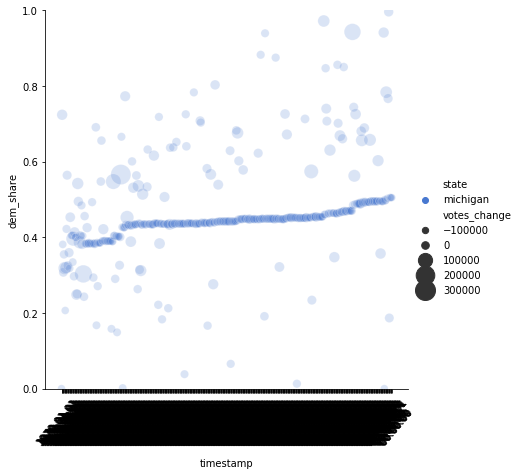

In [11]:
michigan = data[data['state'] == 'michigan']
plt.figure(figsize=(25, 7))

re = sns.relplot(x="timestamp", y="dem_share", hue="state", size="votes_change",
            sizes=(40, 400), alpha=.2, palette="muted",
            height=6, data=michigan)

re.set(ylim=(0, 1))

ax = plt.gca()
xticks = ax.get_xticks()
ax.set_xticklabels([pd.to_datetime(tm, unit='ms').strftime('%Y-%m-%d\n %H:%M:%S') for tm in xticks],
 rotation=50)

plt.show()

<Figure size 1800x864 with 0 Axes>

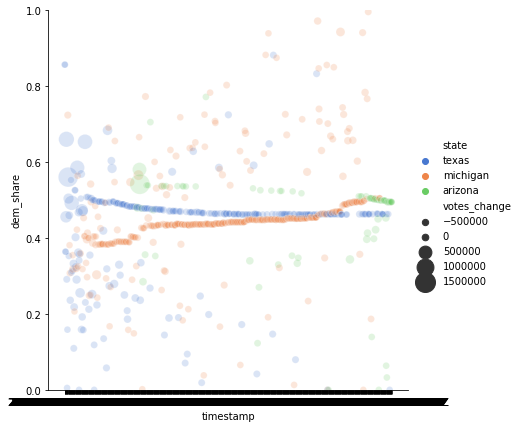

In [12]:
texas = data[data['state'] == 'texas']
arizona = data[data['state'] == 'arizona']

ari_tex_mi = pd.concat([arizona, michigan, texas])

ari_tex_mi = ari_tex_mi.sort_values(by='timestamp', ascending=True)

#sns.set(rc={'figure.figsize':(11.7,18.27)})
#style.use('seaborn-poster') #sets the size of the charts
#style.use('ggplot')

plt.figure(figsize=(25, 12))

re = sns.relplot(x="timestamp",
                 y="dem_share",
                 hue="state",
                 size="votes_change",
                 sizes=(40, 400),
                 alpha=.2,
                 palette="muted",
                 height=6,
                 data=ari_tex_mi)

re.set(ylim=(0, 1))

ax = plt.gca()
xticks = ax.get_xticks()
#ax.set_xticklabels([pd.to_datetime(tm, unit='ms').strftime('%Y-%m-%d\n %H:%M:%S') for tm in xticks],
# rotation=50)

plt.show()

<Figure size 1800x504 with 0 Axes>

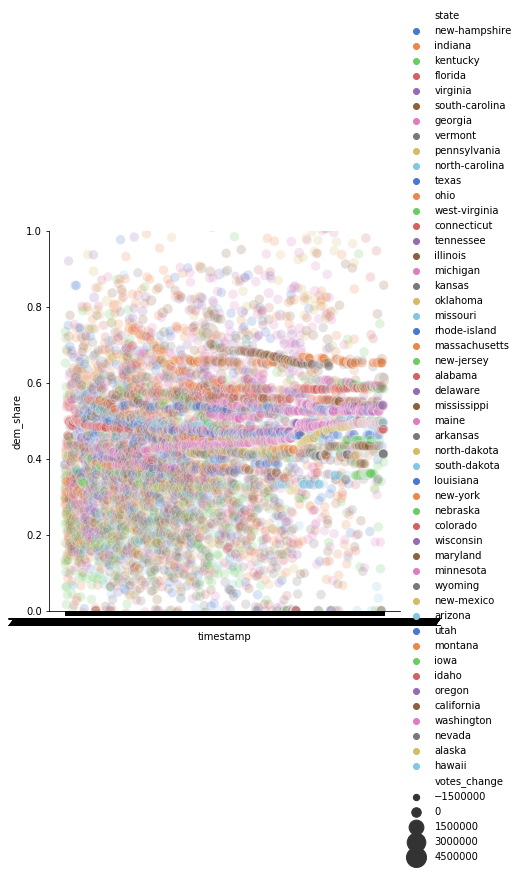

In [13]:
data = data.sort_values(by='timestamp', ascending=True)

plt.figure(figsize=(25, 7))

re = sns.relplot(x="timestamp",
                 y="dem_share",
                 hue="state",
                 size="votes_change",
                 sizes=(40, 400),
                 alpha=.2,
                 palette="muted",
                 height=6,
                 data=data)

re.set(ylim=(0, 1))

ax = plt.gca()
xticks = ax.get_xticks()
#ax.set_xticklabels([pd.to_datetime(tm, unit='ms').strftime('%Y-%m-%d\n %H:%M:%S') for tm in xticks],
# rotation=50)

plt.show()

In [14]:
# #print(sns.scatterplot(data=michigan, x="timestamp", y="dem_share"))
# #print(sns.scatterplot(data=michigan, x="timestamp", y="rep_share"))

# # Create figure and plot space
# fig, ax = plt.subplots(figsize=(12, 12))


# # Define the date format
# date_form = DateFormatter("%Y-%m-%d %H:%M:%S")

# locator = AutoDateLocator()
# formatter = ConciseDateFormatter(locator)

# #ax.xaxis.set_major_formatter(date_form)

# # Ensure a major tick for each week using (interval=1) 
# #ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))

# fig, ax = plt.subplots(constrained_layout=True)
# locator = mdates.AutoDateLocator()
# formatter = mdates.ConciseDateFormatter(locator)
# ax.xaxis.set_major_locator(locator)
# ax.xaxis.set_major_formatter(formatter)

# # Add x-axis and y-axis
# ax.scatter(michigan['timestamp'],
#        michigan['dem_share'],
#        color='purple')

# # Set title and labels for axes
# ax.set(xlabel="Date",
#        ylabel="Precipitation (inches)",
#        title="Daily Total Precipitation\nJune - Aug 2005 for Boulder Creek")



# plt.show()
